In [1]:
import os
import pickle
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import StratifiedKFold

pd.set_option("max_columns", 150)
pd.set_option('display.max_rows', 150)

In [2]:
# This is based on the notebook below which has 17.84127 LB score.
# https://www.kaggle.com/ttkagglett/petfinder-inference-with-fastai?scriptVersionId=84526827
models = ["petfinder_swin_binary_ss2_meta_0.pt",
          "petfinder_effnet_binary_fastai_ss_0.pth",
          "petfinder_beit_binary_fastai_0.pth",
          "petfinder_vit_binary_fastai_mixup_0.pth",
          "petfinder_swin384_binary_fastai_0.pth",
          "petfinder_swin_binary_fastai_ss_0.pth",
          "petfinder_swin_binary_fastai_ss_smogn_0.pth"]

# 17.81281 LB score.
# https://www.kaggle.com/ttkagglett/petfinder-inference-with-fastai?scriptVersionId=85064330
models = ["petfinder_swin_binary_ss2_meta_0.pt",
          "petfinder_effnet_binary_fastai_ss_0.pth",
          "petfinder_beit_binary_fastai_0.pth",
          "petfinder_vit_binary_fastai_mixup_0.pth",
          "petfinder_cait_binary_fastai_mixup_0.pth",
          "petfinder_swin_binary_fastai_highlr_0.pth",
          "petfinder_swin_binary_fastai_ss_0.pth"]

# 17.83021 LB score
# https://www.kaggle.com/ttkagglett/petfinder-inference-with-fastai?scriptVersionId=84974455
models = ["petfinder_swin_binary_ss2_meta_0.pt",
          "petfinder_effnet_binary_fastai_ss_0.pth",
          "petfinder_beit_binary_fastai_0.pth",
          "petfinder_vit_binary_fastai_mixup_0.pth",
          "petfinder_cait_binary_fastai_mixup_0.pth",
          "petfinder_swin384_binary_fastai_0.pth",
          "petfinder_swin_binary_fastai_ss_0.pth"]

In [3]:
df_train = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
#df_inference_result = pd.read_csv("../input/petfinder-inference-result-with-training-data/inference_result_tta2_bs1_score1784127.csv")
#df_inference_result = pd.read_csv("../input/petfinder-inference-result-with-training-data/inference_result_tta2_bs1_score1781281.csv")
df_inference_result_1 = pd.read_csv("../input/petfinder-inference-result-with-training-data/inference_result_tta2_bs1_score1784127.csv")
df_inference_result_2 = pd.read_csv("../input/petfinder-inference-result-with-training-data/inference_result_tta2_bs1_score1781281.csv")
df_inference_result   = df_inference_result_2.iloc[:, :5].join(df_inference_result_1.iloc[:, 4:6].rename(columns={"4":"5","5":"6"})).join(df_inference_result_2[["order","target"]])
df_inference_result["Id"]          = df_train.Id
df_inference_result["Pawpularity"] = df_inference_result.target
df_inference_result.drop(["target", "order"], axis=1, inplace=True)

print(df_inference_result.shape)
df_inference_result.head(2)

(9860, 9)


,0,1,2,3,4,5,6,Id,Pawpularity
0,41.957062,46.614700,44.142227,48.189121,37.696735,37.625309,43.749546,0007de18844b0dbbb5e1f607da0606e0,63
1,50.497047,45.938053,45.086411,41.967426,40.258675,47.329426,42.746258,0009c66b9439883ba2750fb825e1d7db,42


In [4]:
model_num = df_inference_result.shape[1] - 2

for i in range(model_num):
    y_hat = df_inference_result.iloc[:,i]
    y     = df_inference_result.Pawpularity
    rmse  = round(np.sqrt(mean_squared_error(y_hat, y)), 4)
    print(i, rmse, models[i])
    
y_hat = df_inference_result.iloc[:,:model_num].mean(1)
y     = df_inference_result.Pawpularity
rmse  = round(np.sqrt(mean_squared_error(y_hat, y)), 4)
print("Ensembled", rmse)

0 17.3214 petfinder_swin_binary_ss2_meta_0.pt
1 16.7795 petfinder_effnet_binary_fastai_ss_0.pth
2 17.9336 petfinder_beit_binary_fastai_0.pth
3 17.7364 petfinder_vit_binary_fastai_mixup_0.pth
4 17.747 petfinder_cait_binary_fastai_mixup_0.pth
5 18.0908 petfinder_swin384_binary_fastai_0.pth
6 16.9573 petfinder_swin_binary_fastai_ss_0.pth
Ensembled 17.1239


In [5]:
all_rmses = []

def predict(x, y):
    model = Ridge().fit(x, y)
    y_hat = model.predict(x)
    return y_hat

def all_rmse(n):
    for c in itertools.combinations(range(0,7), n):
        x     = df_inference_result.iloc[:,list(c)]
        y_hat = x.mean(1)
        y     = df_inference_result.Pawpularity
        rmse  = round(np.sqrt(mean_squared_error(y_hat, y)), 4)
        y_hat_ens = predict(x, y)
        rmse_ens  = round(np.sqrt(mean_squared_error(y_hat_ens, y)), 4)
        all_rmses.append([c, rmse, rmse_ens])
    
for i in range(1, 8):
    all_rmse(i)

In [6]:
pd.DataFrame(all_rmses, columns=["combination", "rmse", "rmse_ens"]).sort_values("rmse_ens").head(10)

,combination,rmse,rmse_ens
126,"(0, 1, 2, 3, 4, 5, 6)",17.1239,16.5943
122,"(0, 1, 2, 4, 5, 6)",17.1129,16.5944
123,"(0, 1, 3, 4, 5, 6)",17.0941,16.5964
107,"(0, 1, 4, 5, 6)",17.0761,16.5966
116,"(1, 2, 4, 5, 6)",17.1643,16.6023
125,"(1, 2, 3, 4, 5, 6)",17.1697,16.6023
117,"(1, 3, 4, 5, 6)",17.1391,16.6039
92,"(1, 4, 5, 6)",17.1250,16.6039
119,"(0, 1, 2, 3, 4, 5)",17.1827,16.6098
101,"(0, 1, 2, 4, 5)",17.1810,16.6099


In [7]:
df_stacking_features = df_inference_result.copy()

x = df_stacking_features.iloc[:,:model_num]
y = df_stacking_features.Pawpularity
model = Ridge().fit(x, y)

df_stacking_features["ensembled"]    = x.mean(1)
df_stacking_features["inf_stacking"] = model.predict(x)
df_stacking_features["ens_diff"]     = df_stacking_features.Pawpularity - df_stacking_features.ensembled
df_stacking_features["ens_diff_abs"] = np.abs(df_stacking_features.ens_diff)
df_stacking_features["inf_diff"]     = df_stacking_features.Pawpularity - df_stacking_features.inf_stacking
df_stacking_features["inf_diff_abs"] = np.abs(df_stacking_features.inf_diff)

In [8]:
np.sqrt(mean_squared_error(df_stacking_features.inf_stacking, df_stacking_features.Pawpularity))

16.59432950661851

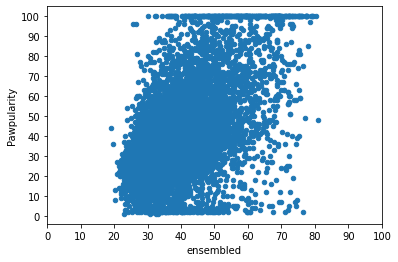

In [9]:
df_stacking_features.plot(x="ensembled", y="Pawpularity", kind="scatter")
plt.xticks(np.arange(0,101,10))
plt.yticks(np.arange(0,101,10))
plt.show()

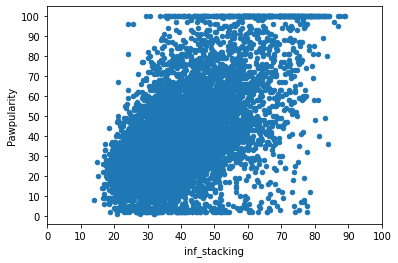

In [10]:
df_stacking_features.plot(x="inf_stacking", y="Pawpularity", kind="scatter")
plt.xticks(np.arange(0,101,10))
plt.yticks(np.arange(0,101,10))
plt.show()

In [11]:
df_stacking_features.sort_values("ens_diff_abs")

,0,1,2,3,4,5,6,Id,Pawpularity,ensembled,inf_stacking,ens_diff,ens_diff_abs,inf_diff,inf_diff_abs
6649,24.716824,28.635824,19.721439,31.457233,28.253004,30.569983,25.662157,ab5602ec4002932525238ec80e828d0e,27,27.002352,25.443084,-0.002352,0.002352,1.556916,1.556916
7948,36.794235,34.406227,42.447662,35.067051,37.844761,35.641132,36.778633,cde00d026a0b84ad613669a77e7ffa3e,37,36.997100,33.150889,0.002900,0.002900,3.849111,3.849111
35,28.472191,28.874481,33.165596,29.152584,28.717974,31.864256,29.800827,00dff6959ce41208a9e0528744162332,30,30.006844,26.474451,-0.006844,0.006844,3.525549,3.525549
5641,50.973442,37.622204,46.210899,33.178574,38.254650,38.740070,41.958870,9181e1bf5ac3f9c7cba4a7e5da000ac3,41,40.991244,39.447815,0.008756,0.008756,1.552185,1.552185
7293,25.029554,27.440994,27.939779,24.699207,32.850105,28.578627,29.523731,bbb00fee6bb0f7d4b67c93a214189819,28,28.008857,24.539742,-0.008857,0.008857,3.460258,3.460258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7985,75.111656,72.831299,70.872452,73.105026,80.912498,71.420937,76.506165,ced7ef91e2927cdd29f89db39373d656,5,74.394290,77.737730,-69.394290,69.394290,-72.737730,72.737730
8857,26.407980,27.227360,25.285435,28.007490,27.688641,23.663393,26.962589,e4ce3f83100dfb93941598570caf9829,96,26.463270,25.811288,69.536730,69.536730,70.188712,70.188712
2630,30.649137,30.514986,29.477453,32.586693,31.589771,26.559711,29.758656,43dd26a5de4bf886ec1043a4490d4f0d,100,30.162344,29.455683,69.837656,69.837656,70.544317,70.544317
2806,26.231915,25.982845,24.749958,28.512281,25.109922,24.310312,24.871679,4831f6e12c448078718a7688dd6ba901,96,25.681273,24.038327,70.318727,70.318727,71.961673,71.961673


In [12]:
pickle.dump(model, open("./stacking_model.pickle", 'wb'))